# Figure 3

### Summary
This script makes Figure 3, showing flash initiation density, pseudo tendency metric, fragmentation metric and storm status for Cypress, Katy and Splendora tornadoes.

### Input
This script uses the `exported.dat` file obtained from using the lasso selection tool in the XLMA software and the flash initiation files obtained by using the `lmatools` package. 

### Output
This script generates a `.png` image of Figure 3.

In [1]:
# libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import detrend
import matplotlib.dates as mdates

plt.rcParams.update({"xtick.labelsize": 12, "ytick.labelsize": 12})

In [2]:
# variables

# these flash initiation files are processed using the output of the lmatools package
CYPRESS_FLASH_INIT = r"data/flash initiation/cypress_fi.csv"
SPLENDORA_KATY_FLASH_INIT = r"data/flash initiation/splendora_katy_fi.csv"

TORNADO_PHASES = [(pd.Timestamp("2025-11-24 19:20:00"), pd.Timestamp("2025-11-24 19:50:00")), (pd.Timestamp("2024-12-28 16:30:00"),  pd.Timestamp("2024-12-28 17:00:00")), (pd.Timestamp("2024-12-28 18:00:00"), pd.Timestamp("2024-12-28 18:30:00"))]

In [3]:
# preparing data

left_df = pd.read_csv(CYPRESS_FLASH_INIT, parse_dates=['datetime'])
left_df.sort_values('datetime', inplace=True)
right_df = pd.read_csv(SPLENDORA_KATY_FLASH_INIT, parse_dates=['datetime'])
right_df.sort_values('datetime', inplace=True)

cypress_spc = pd.DataFrame({
    "label": ["EF1 Cypress", "EF2 Klein"],
    "datetime": [ pd.Timestamp("2025-11-24 19:26:00"), pd.Timestamp("2025-11-24 19:46:00"), ],
    "lat": [29.94, 30.04],
    "lon": [-95.68, -95.54],
})

splendora_katy_spc = pd.DataFrame({
    "label": ["Katy", "Splendora"],
    "datetime": [ pd.Timestamp("2024-12-28 16:40:00"), pd.Timestamp("2024-12-28 18:18:00"), ]
})

In [4]:
# processing data

left_detrend = detrend(left_df['curl_tendency'].values)
right_detrend = detrend(right_df['curl_tendency'].values)
persist_fracs = []
duty_vals = []
DT_SEC = 30.0
# calculating frag metric, and storm status
def frag_metric(df):
    t = df["datetime"]
    curl = df['curl_tendency'].values
    fi = df["fi_density"].values
    # generating active flash threshold
    FI_THRESH = np.nanpercentile(fi, 40)
    active_mask = ( (fi > FI_THRESH) & (np.abs(curl) < np.nanpercentile(np.abs(curl), 70)))
    curl_active = curl[active_mask]
    # stability threshold based on active period
    eps = 0.25 * np.nanstd(curl_active)
    # fraction of time spent in low curl
    persist_fracs.append(np.mean(np.abs(curl_active) < eps))
    duty_vals.append(active_mask.mean())
    # rolling window for storm status calculation
    WINDOW = int((5 * 60) / DT_SEC)
    persist_series = (pd.Series(np.abs(curl) < eps, index=t).rolling(WINDOW, center=True).mean())
    org_binary = (active_mask & (np.abs(curl) < eps)).astype(int)
    transitions = np.abs(np.diff(org_binary))
    frag_abs = transitions.sum() / len(org_binary)
    frag_active = transitions.sum() / max(org_binary.sum(), 1)
    status = []
    for i in range(len(df)):
        is_active = fi[i] > FI_THRESH
        is_stable = persist_series.iloc[i] >= 0.6 if not np.isnan(persist_series.iloc[i]) else False
        is_reorg = np.abs(curl[i]) > eps
        if not is_active:
            state = 0
        elif is_active and is_reorg and not is_stable:
            state = 1
        elif is_active and not is_reorg and not is_stable:
            state = 2
        elif is_active and is_stable:
            state = 3
        else:
            state = -1
        status.append(state)
    df["storm_status"] = status
    return persist_series
    
left_fm = frag_metric(left_df)
right_fm = frag_metric(right_df)

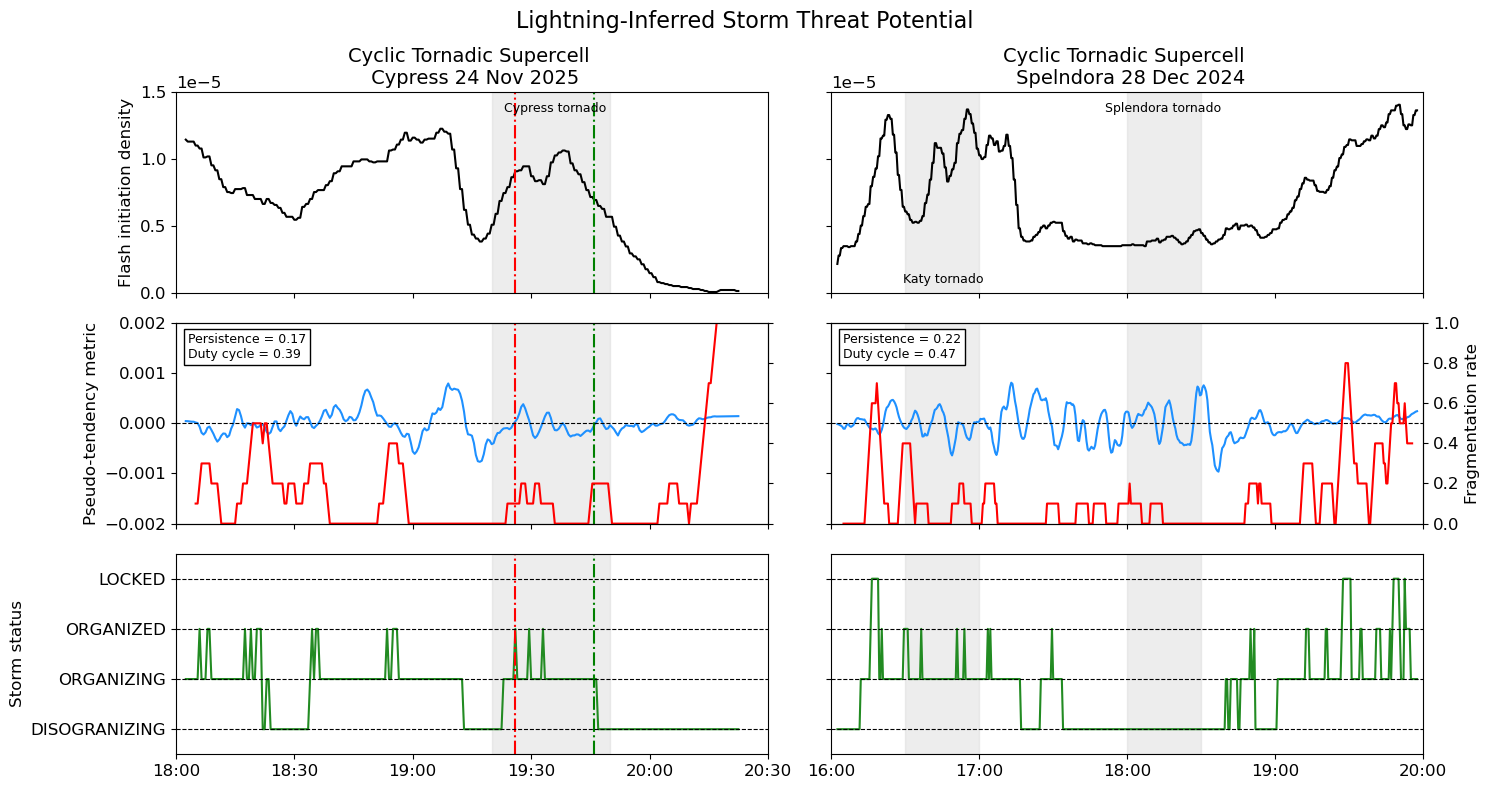

In [5]:
# figure 3
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(3, 2, width_ratios=[1.0, 1.0], height_ratios=[1.0, 1.0, 1.0])

# setting up axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharey=ax3, sharex=ax2)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharey=ax5, sharex=ax2)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
ax32 = ax3.twinx()
ax42 = ax4.twinx()

# cypress case
# flash initiation density
ax1.plot(left_df['datetime'], left_df['fi_density'], color='black')
# pseudo tendency and fragmentation metric
ax3.plot(left_df['datetime'], left_detrend, color='dodgerblue')
ax32.plot(left_df['datetime'], left_fm, color='red')
# storm status
ax5.plot(left_df['datetime'], left_df['storm_status'], color='forestgreen')
# tornado phases
ax1.axvspan(TORNADO_PHASES[0][0], TORNADO_PHASES[0][1], color="lightgray", alpha=0.4)
ax3.axvspan(TORNADO_PHASES[0][0], TORNADO_PHASES[0][1], color="lightgray", alpha=0.4)
ax5.axvspan(TORNADO_PHASES[0][0], TORNADO_PHASES[0][1], color="lightgray", alpha=0.4)
# spc report vertical lines
ax1.axvline(cypress_spc.iloc[0].datetime, color="red", linestyle="-.", label='First tornado report')
ax1.axvline(cypress_spc.iloc[1].datetime, color="green", linestyle="-.", label='Final tornado report')
ax3.axvline(cypress_spc.iloc[0].datetime, color="red", linestyle="-.", label='First tornado report')
ax3.axvline(cypress_spc.iloc[1].datetime, color="green", linestyle="-.", label='Final tornado report')
ax5.axvline(cypress_spc.iloc[0].datetime, color="red", linestyle="-.", label='First tornado report')
ax5.axvline(cypress_spc.iloc[1].datetime, color="green", linestyle="-.", label='Final tornado report')

# axes formatting
ax32.set_ylim(0.0, 1.0)
plt.setp(ax32.get_yticklabels(), visible=False)
ax3.set_ylim(-0.002, 0.002)
ax3.set_ylabel('Pseudo-tendency metric', fontsize=12)
ax3.text(0.02, 0.95, f"Persistence = {persist_fracs[0]:.2f}\nDuty cycle = {duty_vals[0]:.2f}", transform=ax3.transAxes, va="top", fontsize=9, bbox=dict(boxstyle="square", facecolor="white"))
ax5.set_ylim(-0.5, 3.5)
ax5.set_yticks([0, 1, 2, 3])
ax5.set_yticklabels(['DISOGRANIZING', 'ORGANIZING', 'ORGANIZED', 'LOCKED'])
ax5.set_ylabel('Storm status', fontsize=12)
ax5.set_xlim(pd.Timestamp("2025-11-24 18:00:00"), pd.Timestamp("2025-11-24 20:30:00"))
ax5.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax5.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.set_ylim(0.0, 1.5e-5)
ax1.set_ylabel('Flash initiation density', fontsize=12)
ax1.set_title('Cyclic Tornadic Supercell \n Cypress 24 Nov 2025', fontsize=14)
ax2.set_title('Cyclic Tornadic Supercell \n Spelndora 28 Dec 2024', fontsize=14)


# splendora katy case
# flash initiation density
ax2.plot(right_df['datetime'], right_df['fi_density'], color='black')
# pseudo tendency and fragmentation metric
ax4.plot(right_df['datetime'], right_detrend, color='dodgerblue')
ax42.plot(right_df['datetime'], right_fm, color='red')
# storm status
ax6.plot(right_df['datetime'], right_df['storm_status'], color='forestgreen')
# tornado phases
ax2.axvspan(TORNADO_PHASES[1][0], TORNADO_PHASES[1][1], color="lightgray", alpha=0.4)
ax4.axvspan(TORNADO_PHASES[1][0], TORNADO_PHASES[1][1], color="lightgray", alpha=0.4)
ax6.axvspan(TORNADO_PHASES[1][0], TORNADO_PHASES[1][1], color="lightgray", alpha=0.4)
ax2.axvspan(TORNADO_PHASES[2][0], TORNADO_PHASES[2][1], color="lightgray", alpha=0.4)
ax4.axvspan(TORNADO_PHASES[2][0], TORNADO_PHASES[2][1], color="lightgray", alpha=0.4)
ax6.axvspan(TORNADO_PHASES[2][0], TORNADO_PHASES[2][1], color="lightgray", alpha=0.4)
# spc report vertical lines
ax1.axvline(splendora_katy_spc.iloc[0].datetime, color="red", linestyle="-.", label='Katy tornado')
ax1.axvline(splendora_katy_spc.iloc[1].datetime, color="green", linestyle="-.", label='Splendora tornado')
ax3.axvline(splendora_katy_spc.iloc[0].datetime, color="red", linestyle="-.", label='Katy tornado')
ax3.axvline(splendora_katy_spc.iloc[1].datetime, color="green", linestyle="-.", label='Splendora tornado')
ax5.axvline(splendora_katy_spc.iloc[0].datetime, color="red", linestyle="-.", label='Katy tornado')
ax5.axvline(splendora_katy_spc.iloc[1].datetime, color="green", linestyle="-.", label='Splendora tornado')

# axes formatting
plt.setp(ax4.get_yticklabels(), visible=False)
ax42.set_ylim(0.0, 1.0)
ax42.set_ylabel('Fragmentation rate', fontsize=12)
ax4.text(0.02, 0.95, f"Persistence = {persist_fracs[1]:.2f}\nDuty cycle = {duty_vals[1]:.2f}", transform=ax4.transAxes, va="top", fontsize=9, bbox=dict(boxstyle="square", facecolor="white"))
ax5.set_xlim(pd.Timestamp("2025-11-24 18:00:00"), pd.Timestamp("2025-11-24 20:30:00"))
ax6.set_xlim(pd.Timestamp("2024-12-28 16:00:00"), pd.Timestamp("2024-12-28 20:00:00"))
ax6.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
ax6.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# tornado names
ax1.text(0.64, 0.9, "Cypress tornado", transform=ax1.transAxes, fontsize=9, ha='center')
ax2.text(0.19, 0.05, "Katy tornado", transform=ax2.transAxes, fontsize=9, ha='center')
ax2.text(0.56, 0.9, "Splendora tornado", transform=ax2.transAxes, fontsize=9, ha='center')

# horizontal dotted lines for storm status
ax3.axhline(0, color="k", lw=0.8, ls="--")
ax4.axhline(0, color="k", lw=0.8, ls="--")
ax5.axhline(0, color="k", lw=0.8, ls="--")
ax5.axhline(1, color="k", lw=0.8, ls="--")
ax5.axhline(2, color="k", lw=0.8, ls="--")
ax5.axhline(3, color="k", lw=0.8, ls="--")
ax6.axhline(0, color="k", lw=0.8, ls="--")
ax6.axhline(1, color="k", lw=0.8, ls="--")
ax6.axhline(2, color="k", lw=0.8, ls="--")
ax6.axhline(3, color="k", lw=0.8, ls="--")

# saving figure
fig.suptitle("Lightning-Inferred Storm Threat Potential", fontsize=16)
fig.tight_layout()
plt.savefig("figure3.png", bbox_inches="tight")
plt.show()